In [3]:

import pandas as pd
import numpy as np
from pathlib import Path


# 1. Set up paths

# Project root
project_root = Path("/Users/v/Desktop/Visual/glaucoma_DL_project")
data_path = project_root / "data" / "uwhvf-master" / "CSV" / "VF_Data.csv"
output_path = project_root / "data" / "processed"
output_path.mkdir(parents=True, exist_ok=True)

print(f"Loading data from: {data_path}")

# 2. Load and inspect data

df = pd.read_csv(data_path)
print("Dataset loaded:", df.shape)
print("Columns:", len(df.columns))
print("Unique patients:", df['PatID'].nunique())
print("Unique eyes:", df[['PatID','Eye']].drop_duplicates().shape[0])

# Sort to make sure each eye’s records are ordered
df = df.sort_values(by=["PatID", "Eye", "FieldN"]).reset_index(drop=True)

# 3. Construct triplets (v1, v2 -> v3)

triplets = []

for (pid, eye), group in df.groupby(["PatID", "Eye"]):
    group = group.sort_values("FieldN")
    
    # skip if fewer than 3 visits
    if len(group) < 3:
        continue
    
    # slide over consecutive visits
    for i in range(len(group) - 2):
        v1 = group.iloc[i]
        v2 = group.iloc[i+1]
        v3 = group.iloc[i+2]
        
        triplets.append({
            "PatID": pid,
            "Eye": eye,
            "v1_FieldN": v1["FieldN"],
            "v2_FieldN": v2["FieldN"],
            "v3_FieldN": v3["FieldN"],
            "Age_v1": v1["Age"],
            "Age_v2": v2["Age"],
            "Age_v3": v3["Age"],
            "MTD_v1": v1["MTD"],
            "MTD_v2": v2["MTD"],
            "MTD_v3": v3["MTD"],
            "PSD_v1": v1["PSD"],
            "PSD_v2": v2["PSD"],
            "PSD_v3": v3["PSD"]
        })

triplet_df = pd.DataFrame(triplets)
print("Triplets created:", len(triplet_df))
triplet_df.head(10)

# 4. Save triplets for later model training

save_path = output_path / "triplets_summary.csv"
triplet_df.to_csv(save_path, index=False)
print("Saved triplets summary to:", save_path)

Loading data from: /Users/v/Desktop/Visual/glaucoma_DL_project/data/uwhvf-master/CSV/VF_Data.csv
Dataset loaded: (28943, 184)
Columns: 184
Unique patients: 3871
Unique eyes: 7428
Triplets created: 14117
Saved triplets summary to: /Users/v/Desktop/Visual/glaucoma_DL_project/data/processed/triplets_summary.csv


Loading VF data: /Users/v/Desktop/Visual/glaucoma_DL_project/data/uwhvf-master/CSV/VF_Data.csv
Loading coordinates: /Users/v/Desktop/Visual/glaucoma_DL_project/data/uwhvf-master/CSV/Coord_242.csv
Detected 54 TD columns total.
Blind-spot TD columns to exclude (training): ['TD_26', 'TD_35']
Using 52 TD locations after removing blind spots.
Built X shape: (14117, 2, 52)
Built Y shape: (14117, 52)
Meta rows: (14117, 14)
Saved:
  X -> /Users/v/Desktop/Visual/glaucoma_DL_project/data/features/X_td2ch_L52.npy
  Y -> /Users/v/Desktop/Visual/glaucoma_DL_project/data/features/Y_td_L52.npy
  meta -> /Users/v/Desktop/Visual/glaucoma_DL_project/data/processed/triplets_meta_L52.csv


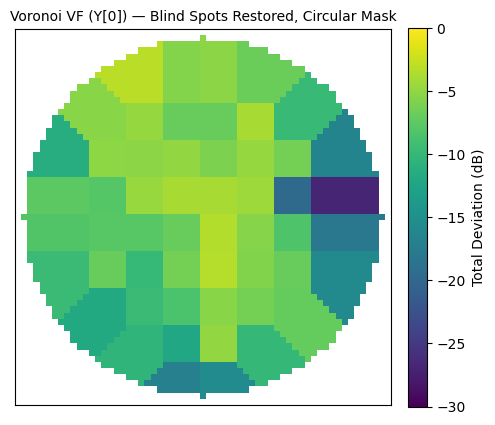

Saved improved circular Voronoi figure -> /Users/v/Desktop/Visual/glaucoma_DL_project/results/figures/vf_voronoi_sample_Y0_circular_clean.png


In [4]:
# === Build model-ready TD tensors (remove blind spots for training)
# === and provide helpers to restore blind spots for visualization ===

import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

# 1) Paths & basic setup
project_root = Path("/Users/v/Desktop/Visual/glaucoma_DL_project")
vf_path      = project_root / "data" / "uwhvf-master" / "CSV" / "VF_Data.csv"
coord_path   = project_root / "data" / "uwhvf-master" / "CSV" / "Coord_242.csv"
out_proc     = project_root / "data" / "processed"
out_feat     = project_root / "data" / "features"
fig_dir      = project_root / "results" / "figures"

out_proc.mkdir(parents=True, exist_ok=True)
out_feat.mkdir(parents=True, exist_ok=True)
fig_dir.mkdir(parents=True, exist_ok=True)

MISSING_STRATEGY = "median"
TD_CLIP = (-35.0, 5.0)

print("Loading VF data:", vf_path)
df = pd.read_csv(vf_path)
print("Loading coordinates:", coord_path)
coords = pd.read_csv(coord_path)

# 2) Identify TD_* columns & remove blind spots
td_cols = [c for c in df.columns if c.startswith("TD_")]
blind_loc_ids = coords.loc[coords["Cluster"] == 0, "LocID"].astype(int).tolist()
blind_td_cols = [f"TD_{lid}" for lid in blind_loc_ids if f"TD_{lid}" in td_cols]
print(f"Detected {len(td_cols)} TD columns total.")
print(f"Blind-spot TD columns to exclude (training): {blind_td_cols}")

td_keep = [c for c in td_cols if c not in blind_td_cols]
L = len(td_keep)
print(f"Using {L} TD locations after removing blind spots.")

col_median = df[td_keep].median()

def prepare_td_vector(row, clip=TD_CLIP, missing=MISSING_STRATEGY):
    v = row[td_keep].to_numpy(dtype=float)
    if missing == "median":
        nan_mask = np.isnan(v)
        if nan_mask.any():
            v[nan_mask] = col_median[nan_mask].to_numpy()
    elif missing == "drop":
        if np.isnan(v).any():
            return None
    if clip is not None:
        v = np.clip(v, clip[0], clip[1])
    return v

# 3) Build consecutive triplets
df = df.sort_values(by=["PatID", "Eye", "FieldN"]).reset_index(drop=True)

X_list, Y_list, meta = [], [], []
for (pid, eye), g in df.groupby(["PatID", "Eye"]):
    g = g.sort_values("FieldN")
    if len(g) < 3:
        continue
    for i in range(len(g) - 2):
        r1, r2, r3 = g.iloc[i], g.iloc[i+1], g.iloc[i+2]
        v1, v2, v3 = prepare_td_vector(r1), prepare_td_vector(r2), prepare_td_vector(r3)
        if v1 is None or v2 is None or v3 is None:
            continue
        X = np.stack([v1, v2], axis=0)
        Y = v3
        X_list.append(X)
        Y_list.append(Y)
        meta.append({
            "PatID": pid, "Eye": eye,
            "v1_FieldN": int(r1["FieldN"]),
            "v2_FieldN": int(r2["FieldN"]),
            "v3_FieldN": int(r3["FieldN"]),
            "Age_v1": float(r1["Age"]),
            "Age_v2": float(r2["Age"]),
            "Age_v3": float(r3["Age"]),
            "MTD_v1": float(r1["MTD"]),
            "MTD_v2": float(r2["MTD"]),
            "MTD_v3": float(r3["MTD"]),
            "PSD_v1": float(r1["PSD"]),
            "PSD_v2": float(r2["PSD"]),
            "PSD_v3": float(r3["PSD"]),
        })

X = np.stack(X_list, axis=0)
Y = np.stack(Y_list, axis=0)
meta_df = pd.DataFrame(meta)

print(f"Built X shape: {X.shape}")
print(f"Built Y shape: {Y.shape}")
print("Meta rows:", meta_df.shape)

# 4) Save arrays and metadata
x_path = out_feat / f"X_td2ch_L{L}.npy"
y_path = out_feat / f"Y_td_L{L}.npy"
m_path = out_proc / f"triplets_meta_L{L}.csv"

np.save(x_path, X)
np.save(y_path, Y)
meta_df.to_csv(m_path, index=False)
print("Saved:")
print("  X ->", x_path)
print("  Y ->", y_path)
print("  meta ->", m_path)

# 5) Helper: restore blind spots back to 54 locations
def fill_blind_spots_52_to_54(td52, blind_locids=tuple(sorted(blind_loc_ids)), fill_strategy="median"):
    td52 = np.asarray(td52, dtype=float)
    assert td52.ndim == 1 and td52.size == 52
    nonblind_locids = [lid for lid in range(1, 55) if lid not in blind_locids]
    td54 = np.full(54, np.nan)
    td54[np.array(nonblind_locids) - 1] = td52
    fill_val = np.nanmedian(td52) if fill_strategy == "median" else 0.0
    for lid in blind_locids:
        td54[lid - 1] = fill_val
    return td54

# 6) Voronoi & visualization utilities
def generate_voronoi_images_given_image_size(data, xy_coordinates, image_size=(61, 61)):
    num_locs = xy_coordinates.shape[0]
    num_obs  = data.shape[0]
    x = xy_coordinates[:, 0] + int(image_size[0] / 2)
    y = xy_coordinates[:, 1] + int(image_size[1] / 2)
    voronoi_points = np.column_stack((x, y))
    xs, ys = np.mgrid[0:image_size[0], 0:image_size[1]]
    grid = np.vstack((xs.ravel(), ys.ravel())).T
    vor_images = np.zeros((num_obs, image_size[0], image_size[1]))
    for k in range(num_obs):
        vals = data[k, :]
        img = np.zeros(image_size)
        for col, row in grid:
            idx = np.argmin((voronoi_points[:, 0] - col)**2 + (voronoi_points[:, 1] - row)**2)
            img[int(col), int(row)] = vals[idx]
        img = np.flipud(img)
        vor_images[k] = img
    return vor_images

def xy_right_eye_order_54(coords_df):
    c = coords_df.sort_values("LocID")
    return c[["X", "Y"]].to_numpy(dtype=float)

def circular_mask(img):
    h, w = img.shape
    cy, cx = h // 2, w // 2
    Y, Xg = np.ogrid[:h, :w]
    radius = min(cx, cy) - 1
    mask = (Xg - cx)**2 + (Y - cy)**2 <= radius**2
    out = img.copy()
    out[~mask] = np.nan
    return out

# 7) Example visualization (circular masked, clean layout)
try:
    td52_example = Y[0]
    td54_example = fill_blind_spots_52_to_54(td52_example)
    xy54 = xy_right_eye_order_54(coords)

    vor = generate_voronoi_images_given_image_size(
        td54_example.reshape(1, -1), xy54, image_size=(61, 61)
    )[0]
    vor_masked = circular_mask(vor)

    fig, ax = plt.subplots(figsize=(5, 5))
    im = ax.imshow(vor_masked, origin="upper", cmap="viridis", vmin=-30, vmax=0)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("Voronoi VF (Y[0]) — Blind Spots Restored, Circular Mask", fontsize=10)

    # put colorbar separately
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Total Deviation (dB)")

    plt.tight_layout()
    out_png = fig_dir / "vf_voronoi_sample_Y0_circular_clean.png"
    plt.savefig(str(out_png), dpi=200, bbox_inches="tight")
    plt.show()
    print("Saved improved circular Voronoi figure ->", out_png)

except Exception as e:
    print("Visualization failed:", e)

In [ ]:
import numpy as np
import pandas as pd

def sample_and_print_triplets(df, n_samples=5, seed=42):
    rng = np.random.default_rng(seed)
    df_sorted = df.sort_values(["PatID","Eye","FieldN"]).reset_index(drop=True)

    printed = 0
    for (pid, eye), g in df_sorted.groupby(["PatID","Eye"]):
        if len(g) < 3:
            continue
       
        starts = np.arange(0, len(g)-2)
        rng.shuffle(starts)
        for i in starts[: min(n_samples-printed, 3)]:  
            r1, r2, r3 = g.iloc[i], g.iloc[i+1], g.iloc[i+2]
            
            assert r1["PatID"] == r2["PatID"] == r3["PatID"] == pid
            assert r1["Eye"]   == r2["Eye"]   == r3["Eye"]   == eye
            assert r1["FieldN"] < r2["FieldN"] < r3["FieldN"]
            assert r1["Time_from_Baseline"] <= r2["Time_from_Baseline"] <= r3["Time_from_Baseline"]

            print(f"[PatID={pid}, Eye={eye}]  "
                  f"Fields: {int(r1['FieldN'])}-{int(r2['FieldN'])}-{int(r3['FieldN'])}  |  "
                  f"Times: {r1['Time_from_Baseline']:.2f} → {r2['Time_from_Baseline']:.2f} → {r3['Time_from_Baseline']:.2f}  |  "
                  f"MTD: {r1['MTD']:.2f} → {r2['MTD']:.2f} → {r3['MTD']:.2f}")
            printed += 1
            if printed >= n_samples:
                return


sample_and_print_triplets(df, n_samples=8)

[PatID=1, Eye=Left]  Fields: 4-5-6  |  Times: 7.95 → 9.00 → 10.28  |  MTD: -11.59 → -8.98 → -7.71
[PatID=1, Eye=Left]  Fields: 3-4-5  |  Times: 6.81 → 7.95 → 9.00  |  MTD: -8.30 → -11.59 → -8.98
[PatID=1, Eye=Left]  Fields: 2-3-4  |  Times: 5.36 → 6.81 → 7.95  |  MTD: -7.58 → -8.30 → -11.59
[PatID=1, Eye=Right]  Fields: 4-5-6  |  Times: 7.95 → 9.00 → 10.28  |  MTD: -6.12 → -5.30 → -4.45
[PatID=1, Eye=Right]  Fields: 3-4-5  |  Times: 6.81 → 7.95 → 9.00  |  MTD: -4.83 → -6.12 → -5.30
[PatID=1, Eye=Right]  Fields: 1-2-3  |  Times: 0.00 → 5.36 → 6.81  |  MTD: -9.09 → -5.97 → -4.83
[PatID=2, Eye=Left]  Fields: 1-2-3  |  Times: 0.00 → 8.03 → 10.02  |  MTD: -6.95 → -3.49 → -4.45
[PatID=2, Eye=Left]  Fields: 4-5-6  |  Times: 11.07 → 12.07 → 15.53  |  MTD: -3.98 → -4.31 → -3.40


In [ ]:
import numpy as np
import pandas as pd

# pre-fun

def load_td_columns(df, coord_df):
    """
    Identify valid TD columns and remove blind spot locations.

    Parameters
    ----------
    df : DataFrame
        The visual field dataset.
    coord_df : DataFrame
        The coordinate file with LocID and Cluster information.

    Returns
    -------
    td_keep : list of str
        List of 52 valid TD column names (blind spots removed).
    blind_loc_ids : list of int
        LocIDs of blind spots (e.g. [26, 35]).
    """

    td_cols = [c for c in df.columns if c.startswith("TD_")]
    blind_loc_ids = coord_df.loc[coord_df["Cluster"] == 0, "LocID"].astype(int).tolist()
    blind_td_cols = [f"TD_{lid}" for lid in blind_loc_ids if f"TD_{lid}" in td_cols]
    td_keep = [c for c in td_cols if c not in blind_td_cols]

    print(f"Detected {len(td_cols)} TD columns total.")
    print(f"Blind-spot TD columns excluded: {blind_td_cols}")
    print(f"Using {len(td_keep)} valid TD locations after removing blind spots.")
    return td_keep, blind_loc_ids


def prepare_td_vector(row, td_keep_cols, col_median=None, clip=(-35.0, 5.0), missing="median"):
    """
    Convert a single VF record (row) into a clean 52-dim TD vector.

    Parameters
    ----------
    row : Series
        A single VF record.
    td_keep_cols : list
        List of valid TD_* column names.
    col_median : Series, optional
        Median values of TD columns for imputation.
    clip : tuple
        Value range to clip (default: (-35, 5)).
    missing : str
        How to handle missing values: 'median' or 'drop'.

    Returns
    -------
    np.ndarray or None
        Clean 1D numpy array (length 52) or None if invalid.
    """

    v = row[td_keep_cols].to_numpy(dtype=float)

    if missing == "median" and col_median is not None:
        nan_mask = np.isnan(v)
        if nan_mask.any():
            v[nan_mask] = col_median[nan_mask].to_numpy()
    elif missing == "drop":
        if np.isnan(v).any():
            return None

    if clip is not None:
        v = np.clip(v, clip[0], clip[1])

    return v


def fill_blind_spots_52_to_54(td52, blind_locids=(26, 35), fill_strategy="median"):
    """
    Restore blind spots (to make full 54-loc VF for visualization).

    Parameters
    ----------
    td52 : np.ndarray
        Input 52-loc TD vector.
    blind_locids : tuple of int
        Blind spot LocIDs (e.g. (26, 35)).
    fill_strategy : str
        'median' or 'zero' filling.

    Returns
    -------
    np.ndarray
        54-length TD vector with blind spots filled.
    """

    td52 = np.asarray(td52, dtype=float)
    assert td52.ndim == 1 and td52.size == 52

    nonblind_locids = [lid for lid in range(1, 55) if lid not in blind_locids]
    td54 = np.full(54, np.nan)
    td54[np.array(nonblind_locids) - 1] = td52

    fill_val = np.nanmedian(td52) if fill_strategy == "median" else 0.0
    for lid in blind_locids:
        td54[lid - 1] = fill_val
    return td54

In [6]:
from itertools import combinations
import numpy as np
import pandas as pd

def build_all_combo_triplets(df, prep_fn, td_keep_cols, min_tests=3, min_span_years=0.0):
    """
    Build all non-consecutive triplet combinations for each patient-eye group.
    
    Parameters
    ----------
    df : DataFrame
        Visual field data (already sorted by PatID, Eye, FieldN)
    prep_fn : function
        Function that converts one row into a TD vector (e.g. prepare_td_vector)
    td_keep_cols : list
        List of TD_* column names to use (after removing blind spots)
    min_tests : int
        Minimum number of tests required for one eye to be included
    min_span_years : float
        Minimum required time difference (years) between first and last test
    
    Returns
    -------
    X : ndarray, shape (N, 2, L)
        Input tensor with two past TD vectors
    Y : ndarray, shape (N, L)
        Target TD vector (future test)
    meta_df : DataFrame
        Metadata table describing each triplet
    """
    df_sorted = df.sort_values(["PatID", "Eye", "FieldN"]).reset_index(drop=True)
    X_list, Y_list, meta = [], [], []
    L = len(td_keep_cols)

    for (pid, eye), g in df_sorted.groupby(["PatID", "Eye"]):
        g = g.sort_values("FieldN")
        if len(g) < min_tests:
            continue

        idx = list(range(len(g)))
        for i, j, k in combinations(idx, 3):
            r1, r2, r3 = g.iloc[i], g.iloc[j], g.iloc[k]

            # Ensure strictly increasing time order
            if not (r1["Time_from_Baseline"] <= r2["Time_from_Baseline"] <= r3["Time_from_Baseline"]):
                continue

            # Enforce minimum overall time span
            if (r3["Time_from_Baseline"] - r1["Time_from_Baseline"]) < min_span_years:
                continue

            v1 = prep_fn(r1); v2 = prep_fn(r2); v3 = prep_fn(r3)
            if v1 is None or v2 is None or v3 is None:
                continue

            X_list.append(np.stack([v1, v2], axis=0))
            Y_list.append(v3)
            meta.append({
                "PatID": pid, "Eye": eye,
                "v1_FieldN": int(r1["FieldN"]), "v2_FieldN": int(r2["FieldN"]), "v3_FieldN": int(r3["FieldN"]),
                "t1": float(r1["Time_from_Baseline"]), "t2": float(r2["Time_from_Baseline"]), "t3": float(r3["Time_from_Baseline"])
            })

    if not X_list:
        return np.empty((0,2,L)), np.empty((0,L)), pd.DataFrame()

    X = np.stack(X_list, axis=0)
    Y = np.stack(Y_list, axis=0)
    meta_df = pd.DataFrame(meta)
    return X, Y, meta_df


# Example: generate all triplets with a minimum 0.5-year time span
X_all, Y_all, meta_all = build_all_combo_triplets(
    df=df,
    prep_fn=prepare_td_vector,
    td_keep_cols=td_keep,
    min_tests=3,
    min_span_years=0.5
)

print("All-combination triplets built:")
print("  X:", X_all.shape)
print("  Y:", Y_all.shape)
print("  meta:", meta_all.shape)

# Save outputs
np.save(out_feat / f"X_triplet_allcomb_L{len(td_keep)}.npy", X_all)
np.save(out_feat / f"Y_triplet_allcomb_L{len(td_keep)}.npy", Y_all)
meta_all.to_csv(out_proc / f"triplets_allcomb_meta_L{len(td_keep)}.csv", index=False)

All-combination triplets built:
  X: (132854, 2, 52)
  Y: (132854, 52)
  meta: (132854, 8)


In [7]:
from itertools import combinations

def build_sequences_generic(
    df, prep_fn, td_keep_cols,
    k_in=2, k_out=1,
    mode="consecutive",         # "consecutive" or "all"
    min_tests=None,
    min_span_years=0.0
):
    """
    Generalized sequence builder for visual field prediction tasks.

    Parameters
    ----------
    df : DataFrame
        Visual field data.
    prep_fn : function
        Function to convert each row into a TD vector.
    td_keep_cols : list
        List of valid TD_* columns (blind spots removed).
    k_in : int
        Number of input visits.
    k_out : int
        Number of future visits to predict (currently supports 1).
    mode : str
        "consecutive" for sliding windows, or "all" for all valid combinations.
    min_tests : int
        Minimum number of tests required per eye (default = k_in + k_out).
    min_span_years : float
        Minimum time gap required between first and last visit.

    Returns
    -------
    X : ndarray, shape (N, k_in, L)
    Y : ndarray, shape (N, L)
    meta_df : DataFrame with sequence details.
    """
    assert k_out == 1, "Currently supports only k_out=1. Extend as needed."
    need = k_in + k_out
    if min_tests is None:
        min_tests = need

    df_sorted = df.sort_values(["PatID", "Eye", "FieldN"]).reset_index(drop=True)
    X_list, Y_list, meta = [], [], []
    L = len(td_keep_cols)

    for (pid, eye), g in df_sorted.groupby(["PatID", "Eye"]):
        g = g.sort_values("FieldN")
        if len(g) < min_tests:
            continue

        idx = list(range(len(g)))
        if mode == "consecutive":
            windows = [tuple(range(s, s+need)) for s in range(0, len(g)-need+1)]
        elif mode == "all":
            windows = combinations(idx, need)
        else:
            raise ValueError("mode must be 'consecutive' or 'all'")

        for win in windows:
            rows = [g.iloc[w] for w in win]
            times = [float(r["Time_from_Baseline"]) for r in rows]
            if not all(times[i] <= times[i+1] for i in range(len(times)-1)):
                continue
            if (times[-1] - times[0]) < min_span_years:
                continue

            inputs = rows[:k_in]
            target = rows[-1]

            vec_in = [prep_fn(r) for r in inputs]
            vec_out = prep_fn(target)
            if any(v is None for v in vec_in) or vec_out is None:
                continue

            X = np.stack(vec_in, axis=0)
            Y = vec_out
            X_list.append(X)
            Y_list.append(Y)
            meta.append({
                "PatID": pid, "Eye": eye,
                "FieldNs": [int(r["FieldN"]) for r in rows],
                "Times": times
            })

    if not X_list:
        return np.empty((0,k_in,L)), np.empty((0,L)), pd.DataFrame()

    X = np.stack(X_list, axis=0)
    Y = np.stack(Y_list, axis=0)
    meta_df = pd.DataFrame(meta)
    return X, Y, meta_df


# Example usage 1: Standard triplet (2→1 consecutive)
X_c, Y_c, M_c = build_sequences_generic(
    df=df, prep_fn=prepare_td_vector, td_keep_cols=td_keep,
    k_in=2, k_out=1, mode="consecutive", min_span_years=0.0
)
print("Consecutive 2→1:", X_c.shape, Y_c.shape)

# Example usage 2: All combinations (2→1) with at least 0.5y between first and last
X_a, Y_a, M_a = build_sequences_generic(
    df=df, prep_fn=prepare_td_vector, td_keep_cols=td_keep,
    k_in=2, k_out=1, mode="all", min_span_years=0.5
)
print("All-combo 2→1 (≥0.5y):", X_a.shape, Y_a.shape)

# Example usage 3: Four-sequence model (3→1 consecutive)
X4, Y4, M4 = build_sequences_generic(
    df=df, prep_fn=prepare_td_vector, td_keep_cols=td_keep,
    k_in=3, k_out=1, mode="consecutive", min_span_years=0.0
)
print("Consecutive 3→1:", X4.shape, Y4.shape)

# Save Example 2
np.save(out_feat / f"X_k{2}_allcomb_L{len(td_keep)}.npy", X_a)
np.save(out_feat / f"Y_k{2}_allcomb_L{len(td_keep)}.npy", Y_a)
M_a.to_csv(out_proc / f"meta_k{2}_allcomb_L{len(td_keep)}.csv", index=False)

Consecutive 2→1: (14117, 2, 52) (14117, 52)
All-combo 2→1 (≥0.5y): (132854, 2, 52) (132854, 52)
Consecutive 3→1: (9665, 3, 52) (9665, 52)
